# Generating MNIST Digits On Demand with a Conditional GAN

This notebook provides you with a complete code example to generate specific MNIST digits on demand with a conditional GAN.

## Loading the MNIST Dataset with PyTorch

Implement the digit transformations ...

In [1]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True),
])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 826133.47it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 276161.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 955910.02it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 14953319.28it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



... and plot some of the transformed MNIST digits.

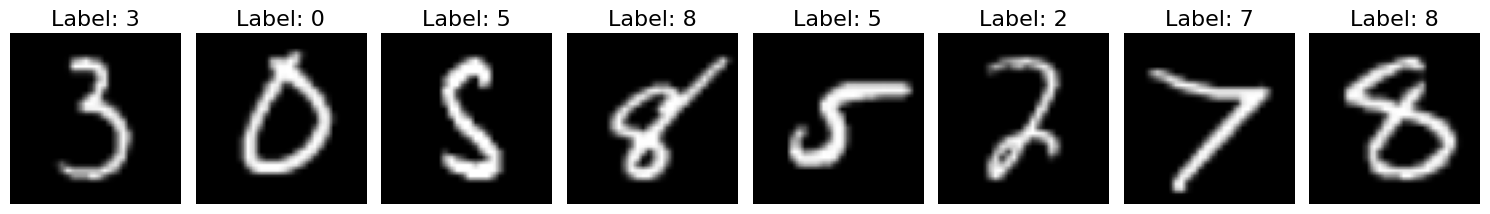

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
    img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=16)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Defining the Generator and Discriminator

Determine the device to be used in the computations ...

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

... instantiating the generator ...

In [5]:
import deeplay as dl

latent_dim = 100

generator = dl.DCGANGenerator(
    latent_dim=latent_dim,
    features_dim=64,
    output_channels=1,
    class_conditioned_model=True,
    embedding_dim=100,
    num_classes=10,    
)
generator.build()
generator.to(device);

print(generator)

DCGANGenerator(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv2dBlock(
      (layer): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Conv2dBlock(
      (layer): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Conv2dBlock(
      (layer): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

... and instantiate the discriminator.

In [6]:
discriminator = dl.DCGANDiscriminator(
    input_channels=1,
    features_dim=64,
    class_conditioned_model=True,
    embedding_dim=100,
    num_classes=10,
)
discriminator.build()
discriminator.to(device);

print(discriminator)

DCGANDiscriminator(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
    )
    (1): Conv2dBlock(
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Conv2dBlock(
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Conv2dBlock(
      (layer): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): ReLU()
      (normalization): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Conv2dBlock(
      (layer): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
      (act

## Training the GAN

Define the data loader ...

In [7]:
from torch.utils.data import DataLoader

batch_size=128

loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                    num_workers=4)

... define the loss function ...

In [8]:
loss = torch.nn.BCELoss()

... define the optimizers ...

In [9]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002,
                               betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002,
                               betas=(0.5, 0.999))

... implement the adversarial training ...


Epoch 1/10
----------


Batch 1/469: Generator Loss: 2.9091, Discriminator Loss: 0.1790
Batch 101/469: Generator Loss: 2.9458, Discriminator Loss: 0.1894
Batch 201/469: Generator Loss: 3.0618, Discriminator Loss: 0.1897
Batch 301/469: Generator Loss: 5.1887, Discriminator Loss: 0.1597
Batch 401/469: Generator Loss: 3.3654, Discriminator Loss: 0.1291
----------
Epoch 1/10: Generator Loss: 3.2150, Discriminator Loss: 0.2284, Time taken: 0:04:06.735922


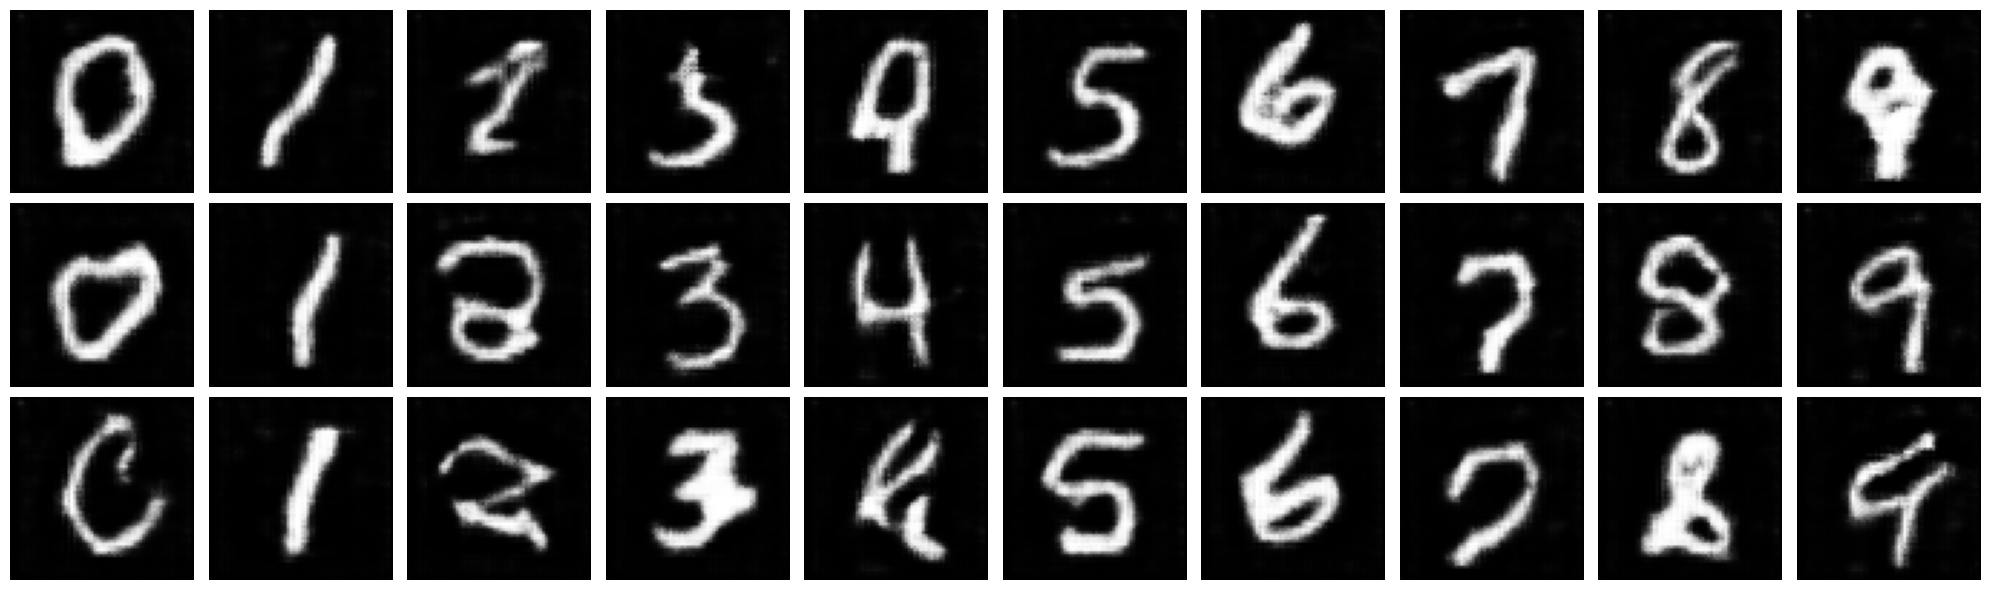


Epoch 2/10
----------
Batch 1/469: Generator Loss: 6.2923, Discriminator Loss: 0.2302
Batch 101/469: Generator Loss: 3.0309, Discriminator Loss: 0.0870
Batch 201/469: Generator Loss: 2.7018, Discriminator Loss: 0.2129
Batch 301/469: Generator Loss: 4.6956, Discriminator Loss: 0.1732
Batch 401/469: Generator Loss: 3.9912, Discriminator Loss: 0.3625
----------
Epoch 2/10: Generator Loss: 3.8945, Discriminator Loss: 0.1957, Time taken: 0:04:04.384763


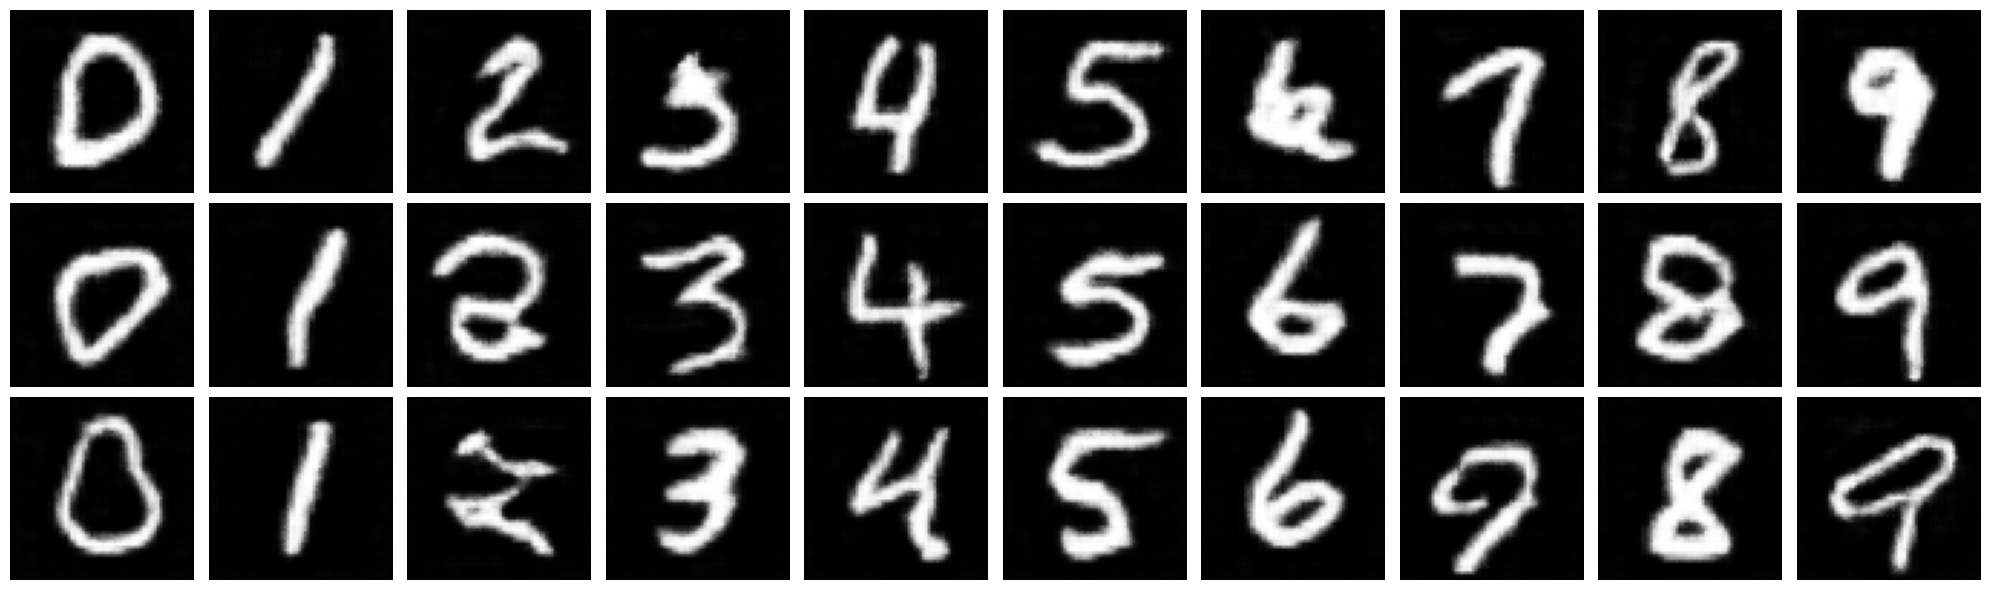


Epoch 3/10
----------
Batch 1/469: Generator Loss: 4.7874, Discriminator Loss: 0.0734
Batch 101/469: Generator Loss: 6.2489, Discriminator Loss: 0.1821
Batch 201/469: Generator Loss: 4.3633, Discriminator Loss: 0.0703
Batch 301/469: Generator Loss: 4.7258, Discriminator Loss: 0.0424
Batch 401/469: Generator Loss: 4.6721, Discriminator Loss: 0.0686
----------
Epoch 3/10: Generator Loss: 4.2611, Discriminator Loss: 0.1721, Time taken: 0:04:04.181540


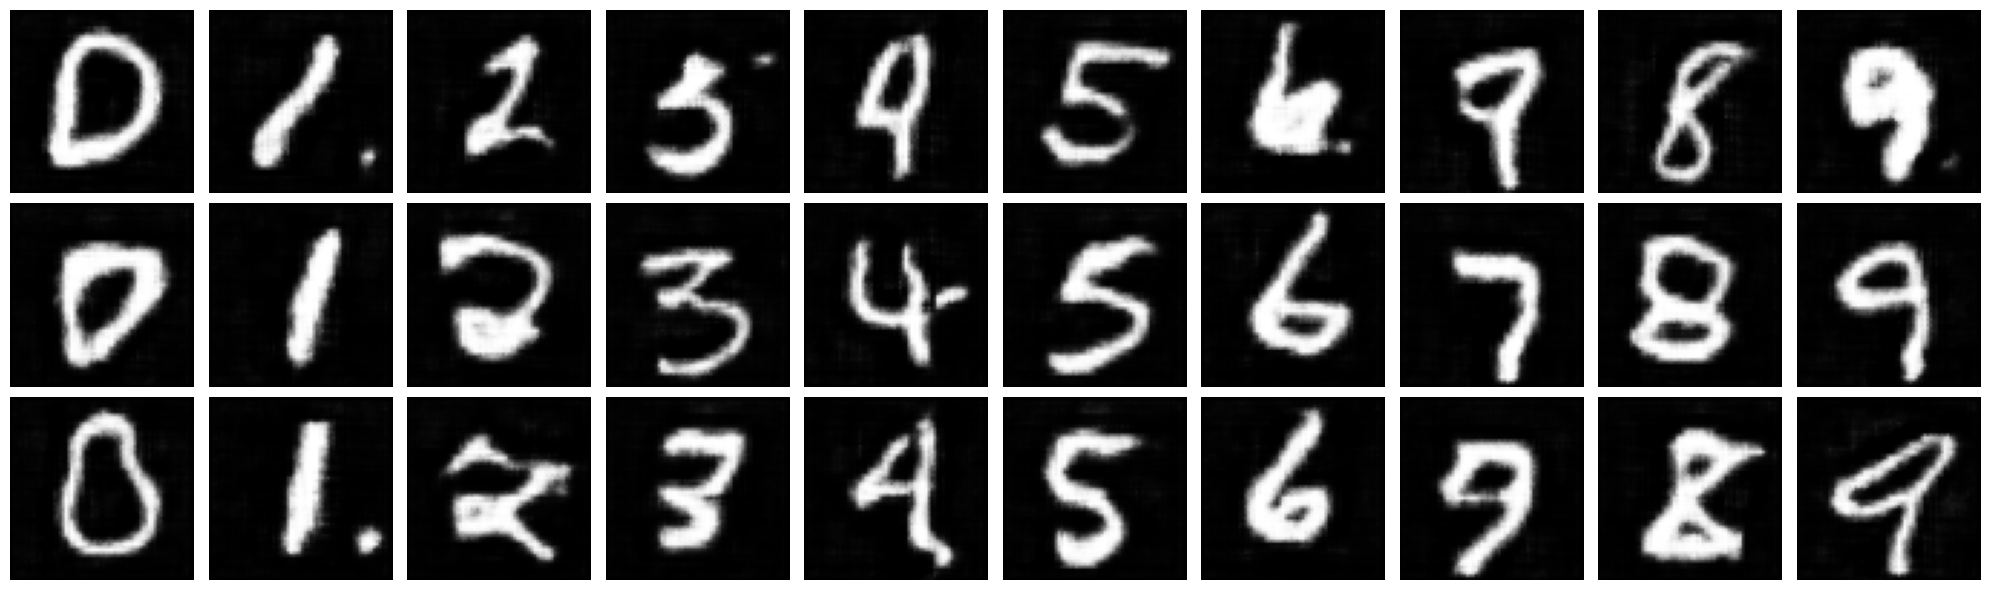


Epoch 4/10
----------
Batch 1/469: Generator Loss: 3.6374, Discriminator Loss: 0.0622
Batch 101/469: Generator Loss: 1.1971, Discriminator Loss: 0.1636
Batch 201/469: Generator Loss: 3.9622, Discriminator Loss: 0.0483
Batch 301/469: Generator Loss: 5.5952, Discriminator Loss: 0.0856
Batch 401/469: Generator Loss: 0.1379, Discriminator Loss: 0.2582
----------
Epoch 4/10: Generator Loss: 4.6929, Discriminator Loss: 0.1406, Time taken: 0:04:03.989217


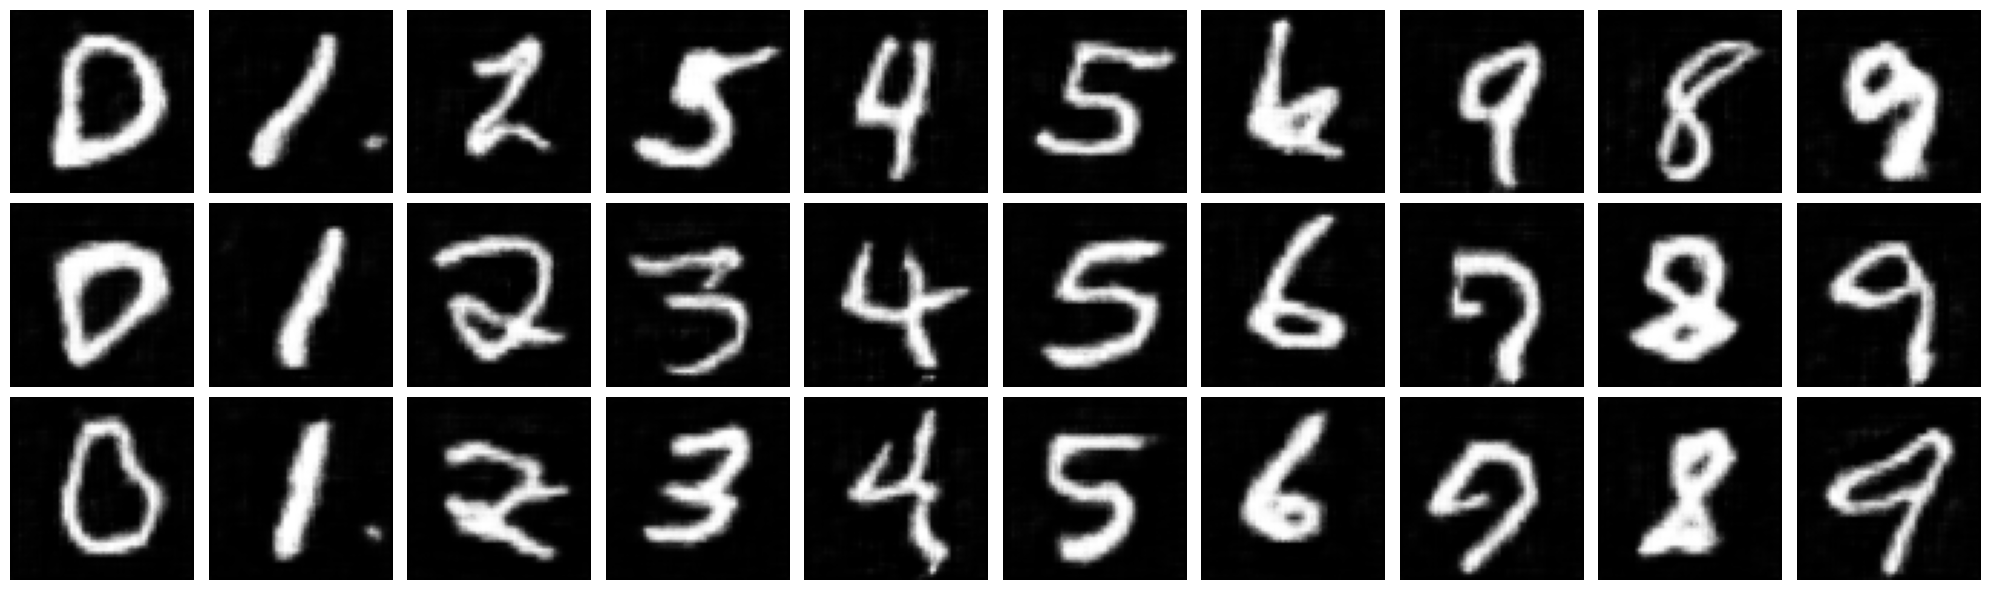


Epoch 5/10
----------
Batch 1/469: Generator Loss: 6.1096, Discriminator Loss: 0.0499
Batch 101/469: Generator Loss: 5.6202, Discriminator Loss: 0.0128
Batch 201/469: Generator Loss: 3.4509, Discriminator Loss: 0.4298
Batch 301/469: Generator Loss: 8.0328, Discriminator Loss: 0.1600
Batch 401/469: Generator Loss: 5.4416, Discriminator Loss: 0.1118
----------
Epoch 5/10: Generator Loss: 4.8624, Discriminator Loss: 0.1489, Time taken: 0:04:03.281985


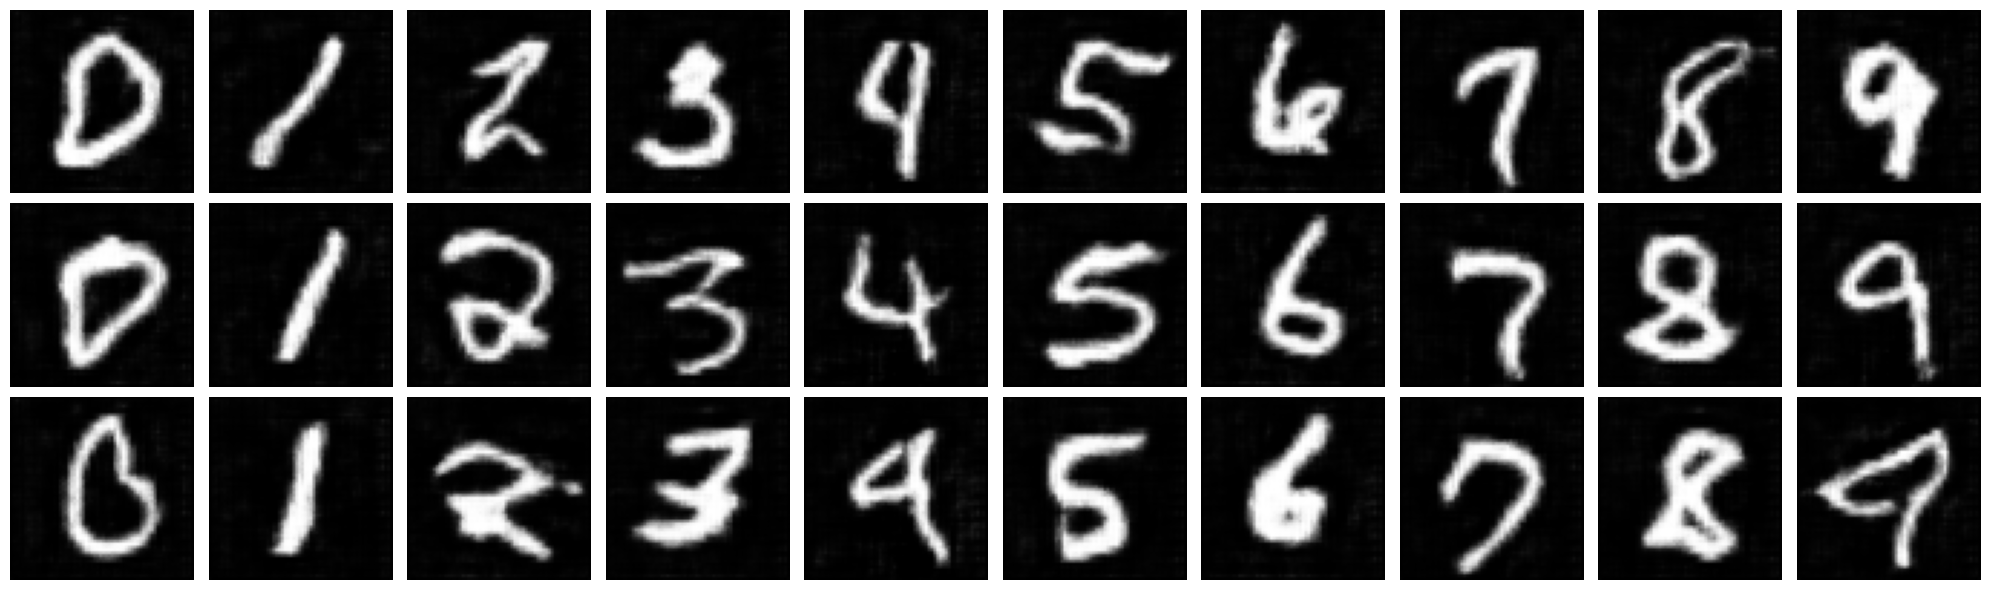


Epoch 6/10
----------
Batch 1/469: Generator Loss: 3.7811, Discriminator Loss: 0.0641
Batch 101/469: Generator Loss: 5.7221, Discriminator Loss: 0.0370
Batch 201/469: Generator Loss: 7.4924, Discriminator Loss: 0.0407
Batch 301/469: Generator Loss: 4.7366, Discriminator Loss: 0.0289
Batch 401/469: Generator Loss: 4.8756, Discriminator Loss: 0.0316
----------
Epoch 6/10: Generator Loss: 4.8927, Discriminator Loss: 0.1401, Time taken: 0:04:04.452730


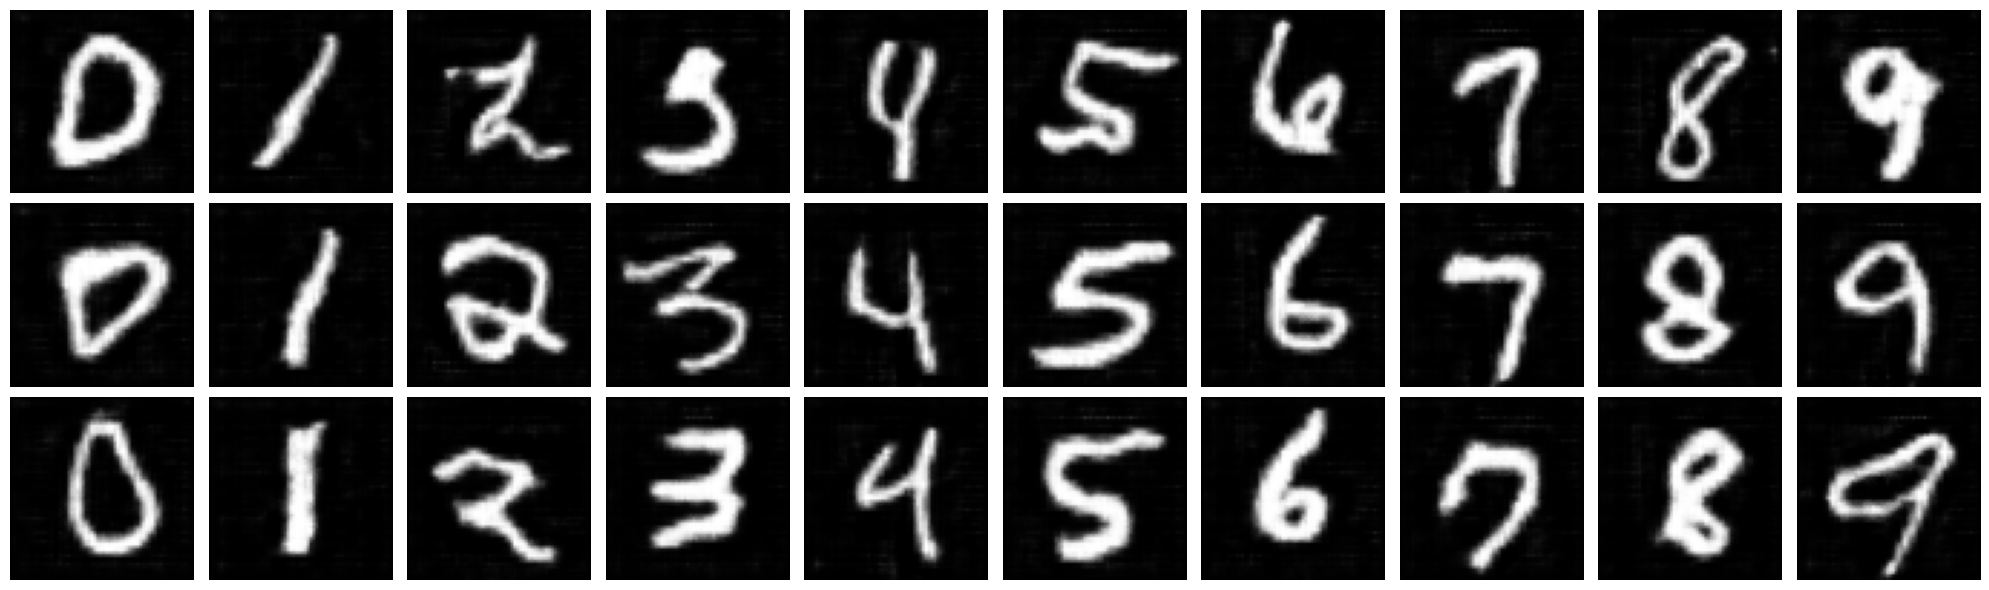


Epoch 7/10
----------
Batch 1/469: Generator Loss: 6.2238, Discriminator Loss: 0.0173
Batch 101/469: Generator Loss: 4.4359, Discriminator Loss: 0.0439
Batch 201/469: Generator Loss: 5.5553, Discriminator Loss: 0.0138
Batch 301/469: Generator Loss: 4.6141, Discriminator Loss: 0.0397
Batch 401/469: Generator Loss: 4.6852, Discriminator Loss: 0.0436
----------
Epoch 7/10: Generator Loss: 5.2167, Discriminator Loss: 0.1115, Time taken: 0:04:03.160519


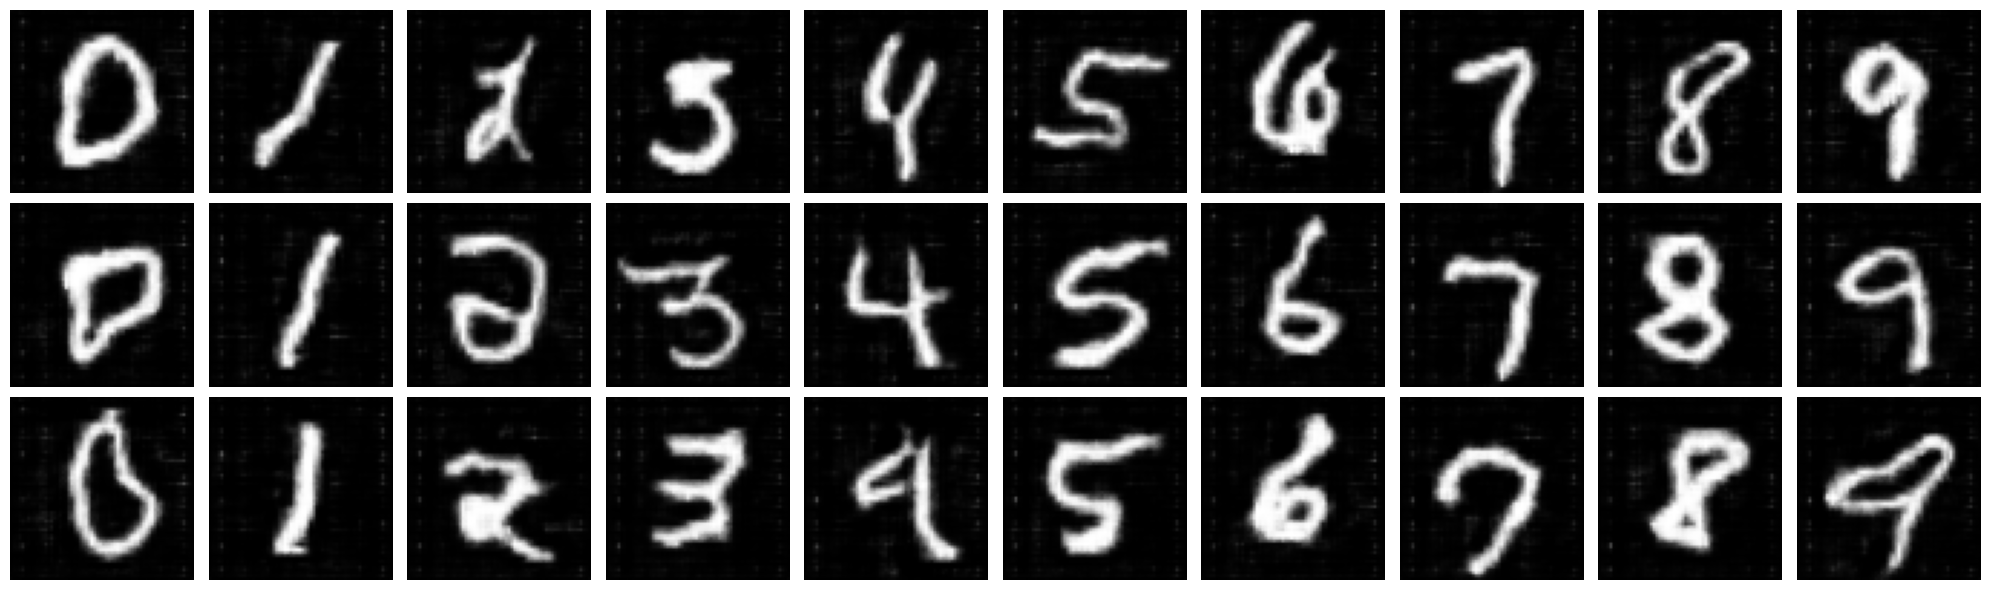


Epoch 8/10
----------
Batch 1/469: Generator Loss: 5.6469, Discriminator Loss: 0.0216
Batch 101/469: Generator Loss: 3.8809, Discriminator Loss: 0.0510
Batch 201/469: Generator Loss: 9.0819, Discriminator Loss: 0.6970
Batch 301/469: Generator Loss: 5.7460, Discriminator Loss: 0.0322
Batch 401/469: Generator Loss: 4.7537, Discriminator Loss: 0.0847
----------
Epoch 8/10: Generator Loss: 5.2808, Discriminator Loss: 0.1299, Time taken: 0:04:03.456143


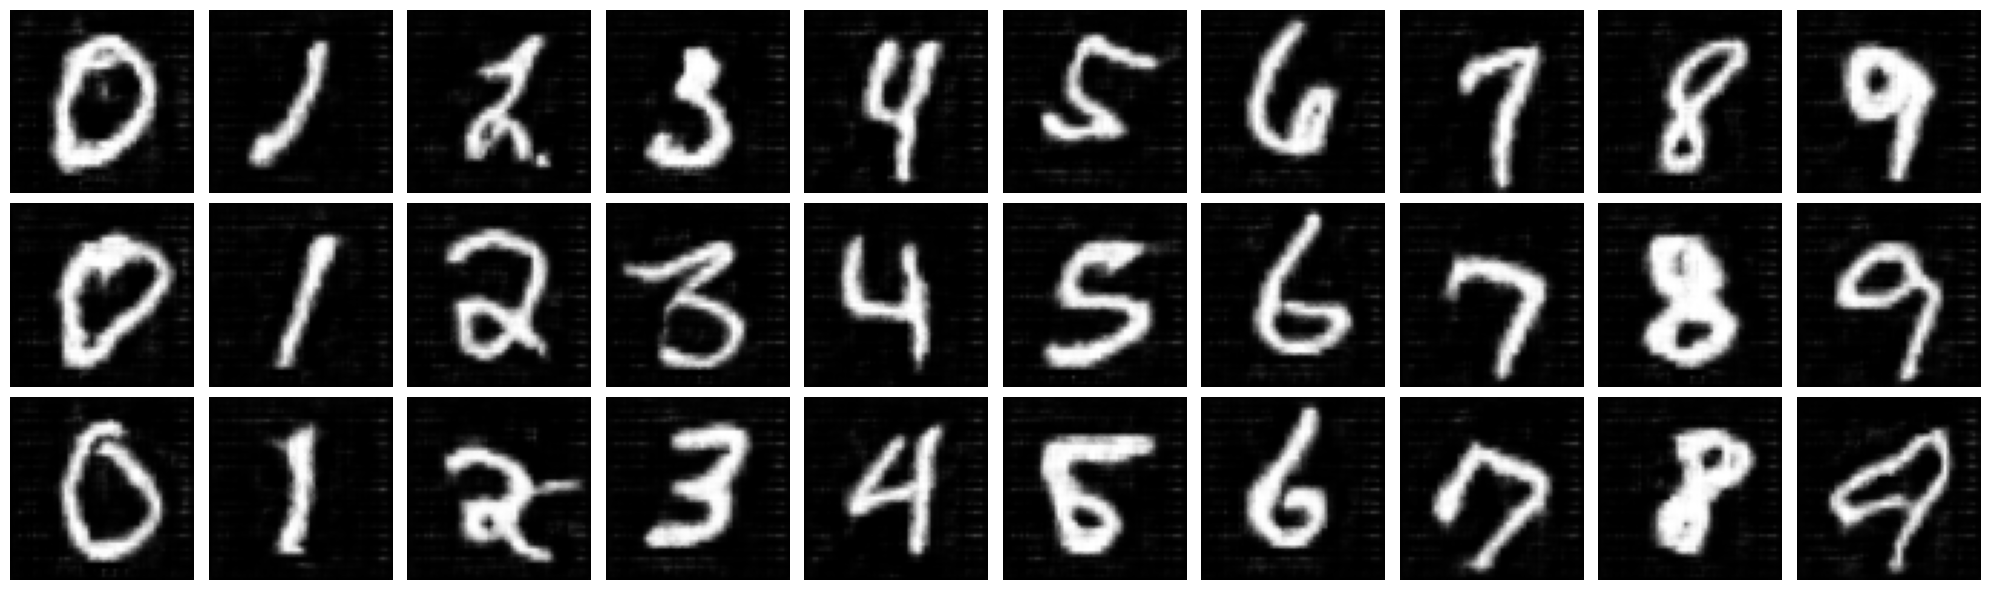


Epoch 9/10
----------
Batch 1/469: Generator Loss: 5.7891, Discriminator Loss: 0.0233
Batch 101/469: Generator Loss: 6.2545, Discriminator Loss: 0.0323
Batch 201/469: Generator Loss: 5.4349, Discriminator Loss: 0.0452
Batch 301/469: Generator Loss: 7.5249, Discriminator Loss: 0.1091
Batch 401/469: Generator Loss: 5.7178, Discriminator Loss: 0.0905
----------
Epoch 9/10: Generator Loss: 5.6294, Discriminator Loss: 0.1146, Time taken: 0:02:34.720834


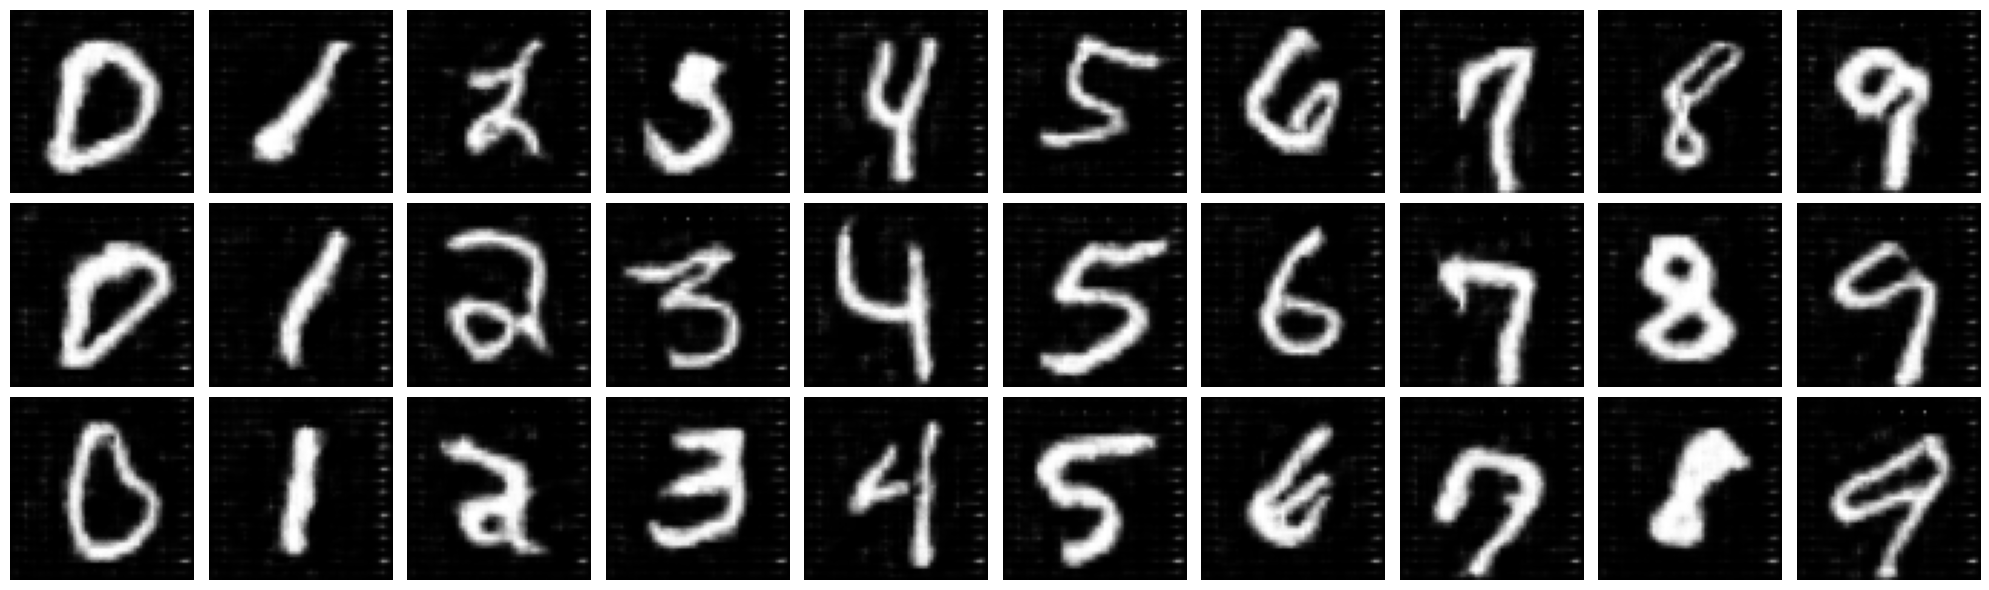


Epoch 10/10
----------
Batch 1/469: Generator Loss: 0.2957, Discriminator Loss: 2.0062
Batch 101/469: Generator Loss: 2.0529, Discriminator Loss: 0.0497
Batch 201/469: Generator Loss: 6.9348, Discriminator Loss: 0.0842
Batch 301/469: Generator Loss: 6.8250, Discriminator Loss: 0.0732
Batch 401/469: Generator Loss: 4.6919, Discriminator Loss: 0.0344
----------
Epoch 10/10: Generator Loss: 5.5697, Discriminator Loss: 0.1125, Time taken: 0:02:05.119712


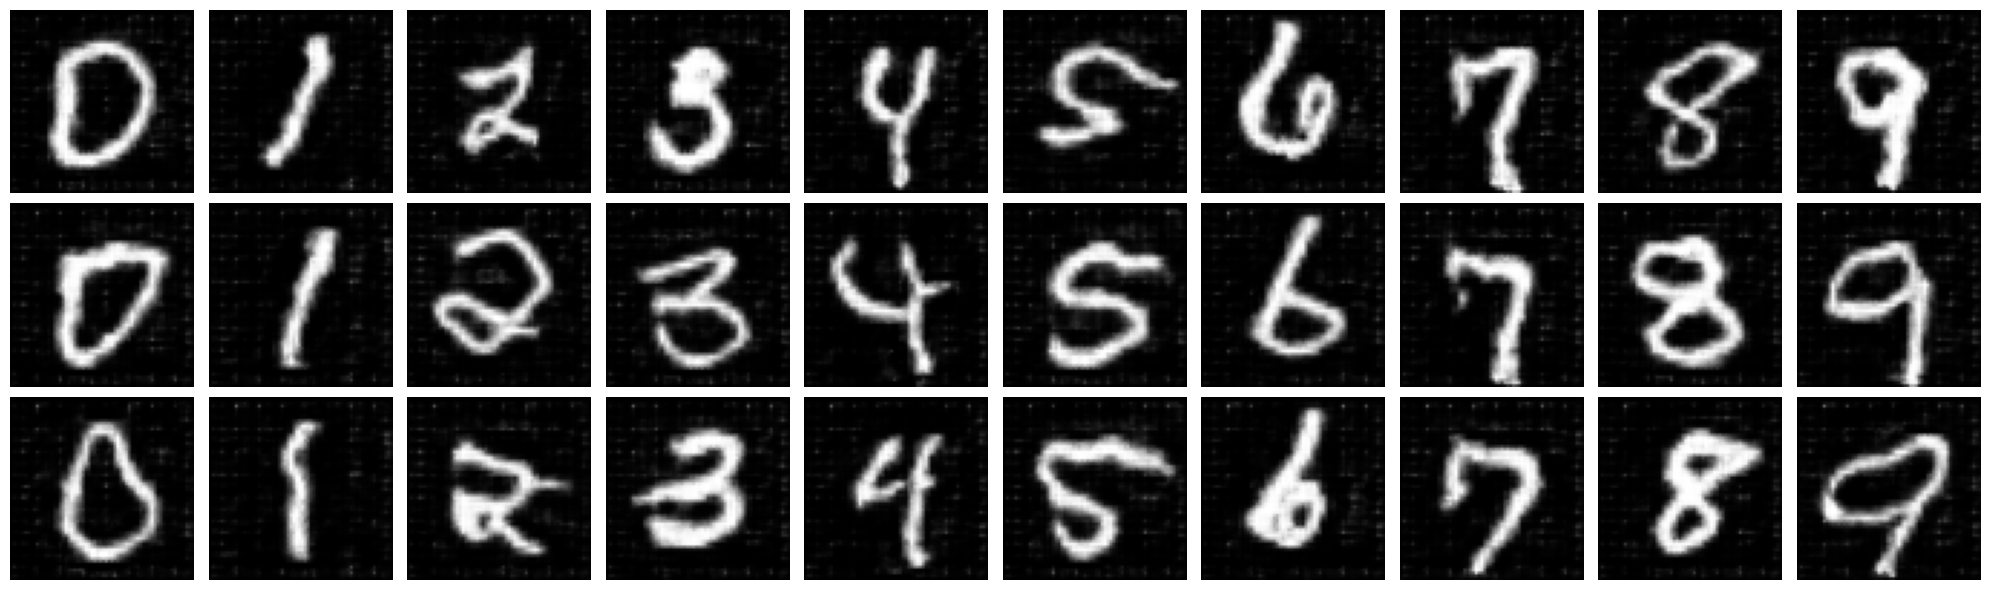

In [15]:
import time
from datetime import timedelta

epochs = 10

num_batches = len(loader)
gen_losses_avg, disc_losses_avg = [], []
fixed_latent_vector = torch.randn(30, latent_dim, 1, 1).to(device)
fixed_class_labels = torch.arange(0, 10).repeat(3).to(device)
for epoch in range(epochs):
    generator.train(), discriminator.train()
    
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "-" * 10)
    start_time = time.time()
    running_gen_loss, running_disc_loss = 0.0, 0.0
    for batch_idx, (real_images, class_labels) in enumerate(loader, start=0):
        real_images = real_images.to(device)
        class_labels = class_labels.to(device)

        noise = torch.randn(real_images.shape[0], latent_dim, 1, 1).to(device)
        fake_images = generator(noise, class_labels)

        # 1.  Discriminator training: minimize - log(D(x)) - log(1 - D(G(z))).
        real_output = discriminator(real_images, class_labels).reshape(-1)
        fake_output = discriminator(fake_images, class_labels).reshape(-1)

        real_loss = loss(real_output, torch.ones_like(real_output))
        fake_loss = loss(fake_output, torch.zeros_like(fake_output))

        discriminator_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        discriminator_loss.backward(retain_graph=True)
        optimizer_D.step()

        # 2.  Generator training: minimize - log(D(G(z))).
        fake_output = discriminator(fake_images, class_labels).reshape(-1)
        generator_loss = loss(fake_output, torch.ones_like(fake_output))

        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: " 
                  + f"Generator Loss: {generator_loss.item():.4f}, " 
                  + f"Discriminator Loss: {discriminator_loss.item():.4f}")

        running_gen_loss += generator_loss.item()
        running_disc_loss += discriminator_loss.item()

    gen_losses_avg.append(running_gen_loss / num_batches)
    disc_losses_avg.append(running_disc_loss / num_batches)
    end_time = time.time()

    print("-" * 10 + "\n"
          + f"Epoch {epoch+1}/{epochs}: " 
          + f"Generator Loss: {gen_losses_avg[-1]:.4f}, "
          + f"Discriminator Loss: {disc_losses_avg[-1]:.4f}, "
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    generator.eval(), discriminator.eval()
    fake_images = generator(fixed_latent_vector, 
                            fixed_class_labels).detach().cpu().numpy()
    fig, axs = plt.subplots(3, 10, figsize=(20, 6))
    for i, ax in enumerate(axs.ravel()):
        ax.imshow(fake_images[i][0], cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

## Plotting the Training Losses

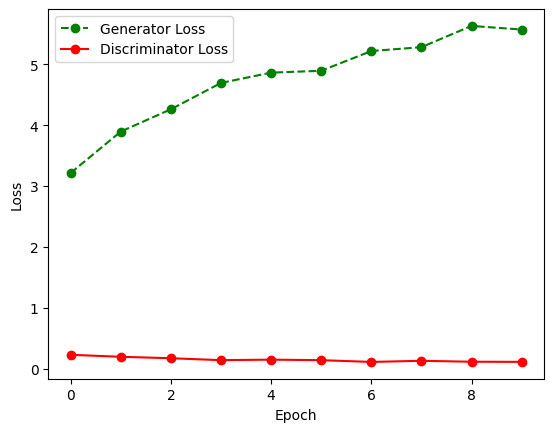

In [16]:
import numpy as np

plt.plot(np.arange(len(gen_losses_avg)), gen_losses_avg, "g--o",
         label="Generator Loss")
plt.plot(np.arange(len(disc_losses_avg)), disc_losses_avg, "r-o",
         label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()